## Building a Filterbank Kernel Model

This notebook is based on the [MNE example](https://mne.tools/dev/auto_examples/decoding/decoding_csp_eeg.html) and illustrates the construction of the filterbank models.

First we load the data as in the original example.

The model here implements the Log-Euclid Kernel model from [Bonet, Malézieux et al 2023, page 7](https://arxiv.org/abs/2303.05798)


Rather than assuming a one set of hyper parameters for the Gaussian Kernel accross all frequencies, here we will tune the hyperparameters independently.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit, cross_val_score

import mne
from mne import Epochs, pick_types, events_from_annotations
from mne.io import concatenate_raws, read_raw_edf
from mne.datasets import eegbci

import coffeine

In [ ]:
mne.set_log_level('critical')

In [ ]:
tmin, tmax = -1.0, 4.0
event_id = dict(hands=2, feet=3)
subject = 1
runs = [6, 10, 14]  # motor imagery: hands vs feet
raw_fnames = eegbci.load_data(subject, runs)
raw = concatenate_raws([read_raw_edf(f, preload=True) for f in raw_fnames])
eegbci.standardize(raw)  # set channel names

In [ ]:
# Apply band-pass filter
raw.filter(4.0, 35.0, fir_design="firwin", skip_by_annotation="edge")

events, _ = events_from_annotations(raw, event_id=dict(T1=2, T2=3))
picks = pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False, exclude="bads")

# Read epochs (train will be done only between 1 and 2s)
# Testing will be done with a running classifier
epochs = Epochs(
    raw,
    events,
    event_id,
    tmin,
    tmax,
    proj=True,
    picks=picks,
    baseline=None,
    preload=True,
)

labels = epochs.events[:, -1] - 2
conditions = ['feet', 'hand']

## Building a coffeine data frame of covariances per frequency

In the following, we compute covariances based on pre-defined frequencies and show how to make a coffeine data frame from them.

In [ ]:
frequency_bands = {
    "theta": (4.0, 8.0),
    "alpha": (8.0, 15.0)
}


def extract_fb_covs(epoch):
    features, meta_info = coffeine.compute_features(
        epoch, features=('covs',), n_fft=1024, n_overlap=512,
        fs=epochs.info['sfreq'], fmax=35, frequency_bands=frequency_bands)
    features['meta_info'] = meta_info
    return features


As this is event-related data and not subject-level data as in [Sabbagh et al 2020](https://www.sciencedirect.com/science/article/pii/S1053811920303797), we need to loop over epochs.

In [ ]:
labels = []
features = []
for i in range(len(epochs)):
    epoch = epochs[i]
    labels.append(list(epoch.event_id.keys())[0])
    feature = extract_fb_covs(epoch)
    features.append(feature['covs'])

We can now make the pandas data frame where each columns is an object array of covariances, which we can represent as a list of covariances.

In [ ]:
X_cov = np.array(features)
X_df = pd.DataFrame(
  {band: list(X_cov[:, ii]) for ii, band in enumerate(frequency_bands)})

Now we can call the model constructor and select our preferred covariance vectorizer, which is the Riemannian tangent-space embedding.
As this makes the assumption of full-rank data, it can be worthwhile to inspect the rank of the data.
As we will see, a rank of 64 seems to be a safe assumption althought it could also be ~60 if on some epochs the rank is lower.
If the rank of covariance is different, it makes sense to take the smallest common rank.

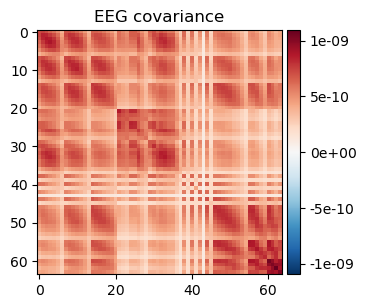

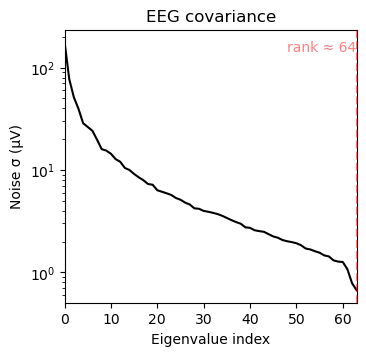

(<Figure size 380x370 with 2 Axes>, <Figure size 380x370 with 1 Axes>)

In [ ]:
mne.compute_covariance(epochs).plot(epochs.info)

In [ ]:
filter_bank_transformer = coffeine.make_filter_bank_transformer(
    names=list(frequency_bands),
    method='riemann',
    projection_params=dict(scale=1, n_compo=60)
)

In [ ]:
class FeaturesKernel(BaseEstimator, TransformerMixin):

    def __init__(self, sigma=1.):
        self.sigma = sigma

    def fit(self, X, y=None):
        if isinstance(X, pd.DataFrame):
            X = X.values
        self.X = X.astype(np.float64)
        self.N = np.sum(self.X ** 2, axis=1)
        return self

    def transform(self, X, y=None):
        C = 1.
        if isinstance(X, pd.DataFrame):
            X = X.values

        X_d = X.astype(np.float64)

        # compute L2 norm across feature vectors in every subject
        N = np.sum(X_d ** 2, axis=1) 
        C1 = self.N[None, :] + N[:, None]
        C2 = (X_d.reshape(X_d.shape[0], -1) @
              self.X.reshape(self.X.shape[0], -1).T)
        C = np.exp(-(C1 - 2 * C2) / (self.sigma ** 2))

        return C

    def get_params(self, deep=True):
        return {"sigma": self.sigma}

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self
    
    
class SumKernel(BaseEstimator, TransformerMixin):

    def __init__(self):
        pass

    def fit(self, X, y=None):
        self.n_train_ = len(X)
        return self

    def transform(self, X, y=None):
        return X.reshape(len(X), -1, self.n_train_).sum(axis=1)


In [ ]:
filter_bank_transformer = coffeine.make_filter_bank_transformer(
    names=list(frequency_bands),
    method='riemann',
    projection_params=dict(scale=1, n_compo=60)
)

In [ ]:
for pipeline, steps, name in filter_bank_transformer.transformers:
    steps.steps.append(('featurekernel', FeaturesKernel()))

In [ ]:
steps

Pipeline(steps=[('projcommonspace',
                 ProjCommonSpace(n_compo=60, reg=1e-05, scale=1)),
                ('riemann', Riemann()), ('featurekernel', FeaturesKernel())])

In [ ]:
Xt_ = filter_bank_transformer.fit_transform(X_df)

<matplotlib.image.AxesImage>

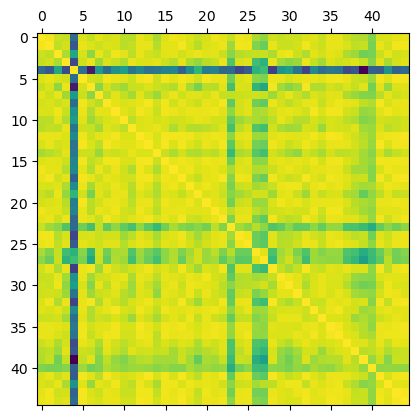

In [ ]:
plt.matshow(Xt_.reshape(len(Xt_), -1, len(Xt_)).sum(1))

In [ ]:
filter_bank_transformer

ColumnTransformer(remainder='passthrough',
                  transformers=[('pipeline-1',
                                 Pipeline(steps=[('projcommonspace',
                                                  ProjCommonSpace(n_compo=60,
                                                                  reg=1e-05,
                                                                  scale=1)),
                                                 ('riemann', Riemann()),
                                                 ('featurekernel',
                                                  FeaturesKernel())]),
                                 'theta'),
                                ('pipeline-2',
                                 Pipeline(steps=[('projcommonspace',
                                                  ProjCommonSpace(n_compo=60,
                                                                  reg=1e-05,
                                                                  scale=1)),
                                                 ('riemann', Riemann()),
                                                 ('featurekernel',
                                                  FeaturesKernel())]),
                                 'alpha')])

In [ ]:
pipeline_kernel = make_pipeline(
    filter_bank_transformer,
    SumKernel(),
    KernelRidge(alpha=1e-10, kernel='precomputed')
)

In [ ]:
pipeline_kernel

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline-1',
                                                  Pipeline(steps=[('projcommonspace',
                                                                   ProjCommonSpace(n_compo=60,
                                                                                   reg=1e-05,
                                                                                   scale=1)),
                                                                  ('riemann',
                                                                   Riemann()),
                                                                  ('featurekernel',
                                                                   FeaturesKernel())]),
                                                  'theta'),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('projcommonspace',
                                                                   ProjCommonSpace(n_compo=60,
                                                                                   reg=1e-05,
                                                                                   scale=1)),
                                                                  ('riemann',
                                                                   Riemann()),
                                                                  ('featurekernel',
                                                                   FeaturesKernel())]),
                                                  'alpha')])),
                ('sumkernel', SumKernel()),
                ('kernelridge',
                 KernelRidge(alpha=1e-10, kernel='precomputed'))])

In [ ]:
y = [1 if ll == 'hands' else -1 for ll in labels]

In [ ]:
 np.logspace(-10, 0, 3)

array([1.e-10, 1.e-05, 1.e+00])

In [ ]:
model = GridSearchCV(
    pipeline_kernel,
    param_grid={
        "columntransformer__pipeline-1__featurekernel__sigma": np.logspace(0, 2, 3),
        "columntransformer__pipeline-2__featurekernel__sigma": np.logspace(0, 2, 3),
    },
    scoring='roc_auc',
    n_jobs=2,
    error_score="raise"
)

model.fit(X_df, y)

GridSearchCV(error_score='raise',
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('pipeline-1',
                                                                         Pipeline(steps=[('projcommonspace',
                                                                                          ProjCommonSpace(n_compo=60,
                                                                                                          reg=1e-05,
                                                                                                          scale=1)),
                                                                                         ('riemann',
                                                                                          Riemann()),
                                                                                         ('featurekernel',
                                                                                          FeaturesKernel())]),
                                                                         'theta'),
                                                                        ('pipeline-2',
                                                                         Pipeline(steps=[('projcommonspace',
                                                                                          P...
                                                                                         ('riemann',
                                                                                          Riemann()),
                                                                                         ('featurekernel',
                                                                                          FeaturesKernel())]),
                                                                         'alpha')])),
                                       ('sumkernel', SumKernel()),
                                       ('kernelridge',
                                        KernelRidge(alpha=1e-10,
                                                    kernel='precomputed'))]),
             n_jobs=2,
             param_grid={'columntransformer__pipeline-1__featurekernel__sigma': array([  1.,  10., 100.]),
                         'columntransformer__pipeline-2__featurekernel__sigma': array([  1.,  10., 100.])},
             scoring='roc_auc')

In [ ]:
cv = ShuffleSplit(5, test_size=0.2, random_state=42)

In [ ]:
scores = cross_val_score(estimator=model, X=X_df, y=y, cv=cv, n_jobs=2)

In [ ]:
print(f'Mean classification accuracy: {np.mean(scores):0.2f}')

Mean classification accuracy: 0.93


In [ ]:
model.best_params_

{'columntransformer__pipeline-1__featurekernel__sigma': 100.0,
 'columntransformer__pipeline-2__featurekernel__sigma': 1.0}